## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel, TFAutoModel, ElectraModel, ElectraTokenizer
from transformers import TFElectraModel
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
strategy = tf.distribute.get_strategy()

## Load Dataset

In [4]:
train = pd.read_csv("../dataset/train.csv", encoding='CP949')
test = pd.read_csv("../dataset/test.csv", encoding='CP949')
sub = pd.read_csv("../dataset/test.csv", encoding='CP949')
train_multinli = pd.read_csv('../dataset/kornli/multinli.train.ko.tsv', delimiter='\t', error_bad_lines=False)
train_snli = pd.read_csv('../dataset/kornli/snli_1.0_train.ko.tsv', delimiter='\t')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 24426: expected 3 fields, saw 4\nSkipping line 156343: expected 3 fields, saw 4\nSkipping line 218766: expected 3 fields, saw 4\nSkipping line 232318: expected 3 fields, saw 4\nSkipping line 253493: expected 3 fields, saw 4\n'
b'Skipping line 265734: expected 3 fields, saw 4\nSkipping line 282588: expected 3 fields, saw 4\nSkipping line 350969: expected 3 fields, saw 4\n'


## EDA

### .head() 함수로 데이터셋에 대한 기본 정보 확인

In [5]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [6]:
test.head()

,index,premise,hypothesis
0,1,진짜 사람하나 캐리어하나만 들어갈수있어요,캐리어는 들어갈 수 없어요.
1,2,그린 아메리카는 우선 대형 초콜릿 제조업체들을 대상으로 설득작업을 벌이고 있습니다.,초콜릿을 만드는 대형 제조업체가 존재한다.
2,3,또한 강연이 끝난 후 각 국의 업무 담당자들로부터 사전 접수한 질문과 함께 현장에서...,질의응답에 사전 접수된 질문은 답변이 제한된다.
3,4,수험생들은 각 상담부스에서 입시전문가나 입학사정관과 상담함으로써 수시모집 지원전략을...,수험생들은 입시전문가와 입학사정관에게 수시모집 지원전략에 대한 도움을 받을 수 있다.
4,5,콜린은 매우 친절하고 응답이 빠릅니다.,콜린이 숙소의 호스트입니다.


In [7]:
sub.head()

,index,premise,hypothesis
0,1,진짜 사람하나 캐리어하나만 들어갈수있어요,캐리어는 들어갈 수 없어요.
1,2,그린 아메리카는 우선 대형 초콜릿 제조업체들을 대상으로 설득작업을 벌이고 있습니다.,초콜릿을 만드는 대형 제조업체가 존재한다.
2,3,또한 강연이 끝난 후 각 국의 업무 담당자들로부터 사전 접수한 질문과 함께 현장에서...,질의응답에 사전 접수된 질문은 답변이 제한된다.
3,4,수험생들은 각 상담부스에서 입시전문가나 입학사정관과 상담함으로써 수시모집 지원전략을...,수험생들은 입시전문가와 입학사정관에게 수시모집 지원전략에 대한 도움을 받을 수 있다.
4,5,콜린은 매우 친절하고 응답이 빠릅니다.,콜린이 숙소의 호스트입니다.


train 19996개, test 5000개

In [8]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")
print(f"train_multinli => {train_multinli.shape}")
print(f"train_snli => {train_snli.shape}")

train shape => (19996, 4) 
test shape => (5000, 3)
train_multinli => (385494, 3)
train_snli => (550152, 3)


In [9]:
train.columns

Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')

In [10]:
train.drop(['index'], axis=1, inplace=True)

In [12]:
train_multinli.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'label'}, inplace=True)

In [13]:
train_snli.rename(columns={'sentence1':'premise', 'sentence2':'hypothesis', 'gold_label':'label'}, inplace=True)

In [14]:
train_multinli = train_multinli.iloc[:20000]

In [15]:
train_snli = train_snli.iloc[:5000]

In [16]:
train_all = pd.concat([train, train_multinli, train_snli], ignore_index=True)

In [17]:
train_all

,premise,hypothesis,label
0,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment
...,...,...,...
44991,오토바이는 오토바이를 타고 무모하다.,오토바이가 차 더미와 충돌한다.,contradiction
44992,오토바이는 오토바이를 타고 무모하다.,오토바이 운전자는 자전거를 탄다.,entailment
44993,오토바이는 오토바이를 타고 무모하다.,오토바이를 타는 사람이 몇 대의 차를 뛰어넘는다.,neutral
44994,누군가가 오토바이를 타고 옆으로 달리고 있다.,기수가 오토바이에 걸터앉고 있다.,contradiction


### 훈련 데이터 결측치 계산  
결측치가 존재해 제거하는 과정을 진행.

In [19]:
train_all.isnull().sum()

premise       0
hypothesis    4
label         1
dtype: int64

In [20]:
train_all.dropna(inplace=True)

In [21]:
train_all.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

In [22]:
train_all.shape

(44991, 3)

In [23]:
train = train_all

### LabelEncoder를 활용해 categorical features를 encode함
contradiction => 0  
entailment => 1  
neutral => 2

In [24]:
categorical_cols = ['label']
for e in categorical_cols:
    le = LabelEncoder()
    train[e] = le.fit_transform(train[e])

In [25]:
train.head()

,premise,hypothesis,label
0,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,0
1,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,1
2,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,2
3,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,2
4,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,1


In [26]:
train['label'].values

array([0, 1, 2, ..., 2, 0, 0])

### 라벨값이 balaced 한지 imbalanced 한지 확인하는 visualization
만약 학습 데이터가 imbalanced 하다면, 추가적인 고민이 필요하지만  
시각화 결과 클래스 값들이 고르게 분포되어 있음.

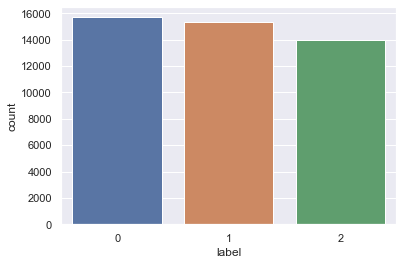

In [27]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

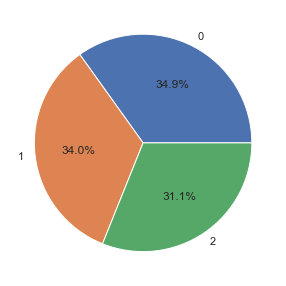

In [28]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## Modeling - KoELECTRA

In [29]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [30]:
model = model_KoELECTRA()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [31]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [32]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

### 패딩 적절 길이 구하기

In [33]:
train_encoded = tokenizer.batch_encode_plus(train_data)
test_encoded = tokenizer.batch_encode_plus(test_data)

Token indices sequence length is longer than the specified maximum sequence length for this model (2084 > 512). Running this sequence through the model will result in indexing errors


In [34]:
cal_length = train_encoded['input_ids'] + test_encoded['input_ids']

num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 42.33372006961253
토큰 길이 최대: 2632
토큰 길이 표준편차: 24.574892421378514


In [35]:
test_num_tokens = [len(tokens) for tokens in test_encoded['input_ids']]

In [36]:
# 평균값, 최댓값, 표준편차
print(f"토큰 길이 최대: {np.max(test_num_tokens)}")

토큰 길이 최대: 98


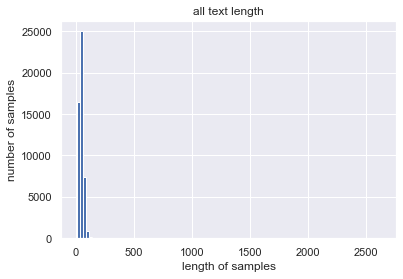

In [37]:
plt.title('all text length')
plt.hist(num_tokens, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [38]:
select_length = 100

In [39]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [40]:
below_threshold_len(select_length, cal_length)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 0.9920785741433458


### 패딩 길이 설정 후 적정 길이보다 큰 데이터 삭제

In [41]:
temp = []
for i in range(len(train_encoded['input_ids'])):
    if len(train_encoded['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del train_data[i]
    train_all.drop(train_all.index[i], inplace=True)
    
temp = []
for i in range(len(test_encoded['input_ids'])):
    if len(test_encoded['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del test_data[i]

In [42]:
len(train_data)

44595

In [43]:
len(test_data)

5000

In [44]:
len(train_all)

44595

### 최종 모델링

In [45]:
train_encoded = tokenizer.batch_encode_plus(train_data, padding='max_length', max_length=select_length)
test_encoded = tokenizer.batch_encode_plus(test_data, padding='max_length', max_length=select_length)

In [46]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded['input_ids'], train_all.label.values, test_size=0.2)
x_test = test_encoded['input_ids']

In [47]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [48]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
tf_electra_model (TFElectraM TFBaseModelOutputWithPast 112330752 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 112,333,059
Trainable params: 112,333,059
Non-trainable params: 0
_________________________________________________________________


In [49]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

history = model.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,validation_data=valid_dataset,epochs= 10)

Epoch 1/10
2229/2229 [==============================] - 503s 221ms/step - loss: 0.5966 - accuracy: 0.7476 - val_loss: 0.5015 - val_accuracy: 0.8049
Epoch 2/10
2229/2229 [==============================] - 488s 219ms/step - loss: 0.3621 - accuracy: 0.8626 - val_loss: 0.5381 - val_accuracy: 0.8106
Epoch 3/10
2229/2229 [==============================] - 488s 219ms/step - loss: 0.2307 - accuracy: 0.9171 - val_loss: 0.6494 - val_accuracy: 0.8153
Epoch 4/10
2229/2229 [==============================] - 487s 218ms/step - loss: 0.1428 - accuracy: 0.9500 - val_loss: 0.7436 - val_accuracy: 0.8151
Epoch 5/10
2229/2229 [==============================] - 487s 219ms/step - loss: 0.0933 - accuracy: 0.9686 - val_loss: 0.8397 - val_accuracy: 0.8096
Epoch 6/10
2229/2229 [==============================] - 488s 219ms/step - loss: 0.0675 - accuracy: 0.9771 - val_loss: 0.9221 - val_accuracy: 0.8118
Epoch 7/10
2229/2229 [==============================] - 487s 218ms/step - loss: 0.0494 - accuracy: 0.9834 - val_

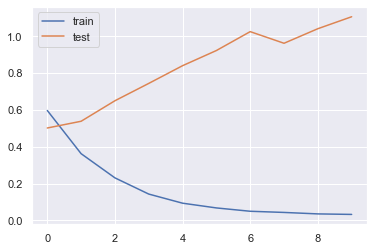

In [50]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(test_dataset, verbose=1)

In [ ]:
predictions_final = predictions.argmax(axis=1)

In [ ]:
len(predictions_final)

In [ ]:
list1 = [i for i in range(5000)]

In [ ]:
list2 = predictions_final

In [ ]:
submission = pd.DataFrame({'index':list1,
                           'label':list2})

In [ ]:
submission

In [ ]:
# contradiction => 0 entailment => 1 neutral => 2
submission['label'].replace(0, 'contradiction', inplace=True)
submission['label'].replace(1, 'entailment', inplace=True)
submission['label'].replace(2, 'neutral', inplace=True)

In [ ]:
submission

## versus previous submission(v4)

In [ ]:
previous = pd.read_csv('../submission/submission_KoELECTRAv4.csv')

In [ ]:
previous['label']

In [ ]:
submission['label']

In [ ]:
cnt_equal = 0
cnt_diff = 0
for i in range(5000):
    if previous['label'][i] == submission['label'][i]:
        cnt_equal += 1
    else: cnt_diff += 1

similarity = cnt_equal/(cnt_equal+cnt_diff) * 100
print(f"이전 제출 파일과의 유사도:{similarity}%")

In [ ]:
submission.to_csv("../submission/submission_KoELECTRAv9.csv", index = False)

In [ ]:
# model.save('competition_KoELECTRA_v2.h5')
# Load model code
# new_model = tf.keras.models.load_model('competition_BERT_v1.h5')
# test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)